In [1]:
import xarray as xr
import math
from pathlib import Path
import geopandas as gpd
from matplotlib import pyplot as plt
from shapely.geometry import box
import pandas as pd
import numpy as np

In [16]:
data_path = Path('/home/oku/Developments/XAI4GEO/data/brazil_data')
ds_path = data_path / 'Tree_labels_merged' / 'tree_labels_merged.zarr'
ds = xr.open_zarr(ds_path)
ds = ds.compute() # Load data into memory since it's small
ds

<xarray.Dataset>
Dimensions:  (sample: 102, x: 256, y: 256, channel: 3)
Dimensions without coordinates: sample, x, y, channel
Data variables:
    X        (sample, x, y, channel) uint8 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0
    Y        (sample) int64 91277344256 91277344256 ... 997207531008
Attributes: (12/15)
    100373655296:  {'ESPECIE': 'Libidibia ferrea', 'TIPO': 'nativa do Brasil'}
    143965381632:  {'ESPECIE': 'Paubrasilia echinata', 'TIPO': 'nativa do Bra...
    236959227904:  {'ESPECIE': 'Euterpe edulis', 'TIPO': 'nativa ameaçada de ...
    245146887168:  {'ESPECIE': 'Pinus elliottii', 'TIPO': 'exotica invasora'}
    267652544512:  {'ESPECIE': 'Syagrus romanzoffiana', 'TIPO': 'nativa'}
    318213318656:  {'ESPECIE': 'Archontophoenix cunninghamiana', 'TIPO': 'exo...
    ...            ...
    762290529280:  {'ESPECIE': 'Cryptomeria japonica', 'TIPO': 'exotica'}
    867124054528:  {'ESPECIE': 'Araucaria angustifolia', 'TIPO': 'ameacada'}
    912749161984:  {'ESPECIE': 'Tachigali denudata', 'TIPO': 'nativa ameaçada...
    91277344256:   {'ESPECIE': 'Cunninghamia lanceolata', 'TIPO': 'exotica in...
    928764938240:  {'ESPECIE': 'Cecropia sp', 'TIPO': 'nativa'}
    997207531008:  {'ESPECIE': 'Anadenanthera colubrina', 'TIPO': 'nativa'}

## Select cutouts

Loop through all unique species in the `ds` dataset and select the cutouts for each species:
1. Select all cutouts from `ds` with number of samples greater than 5.
2. Select the center 128x128 pixels (orgininally it was 256x256)
3. Take the part of cutout the size without zero padding
4. If BOTH sides are less than 64 pixels, interpolate the non-zero part to 64x64 pixels
5. Pad the interpolated image to 128x128 pixels with zeros
6. Save the cutout of each species to a separate zarr file

In [31]:
# Loop through all unique species in the `ds` dataset and select the cutouts for each species:
# 1. Select all cutouts from `ds` with number of samples greater than 5.
# 2. Select the center 128x128 pixels (orgininally it was 256x256)
# 3. Take the part of cutout the size without zero padding
# 4. If BOTH sides are less than 64 pixels, interpolate the non-zero part to 64x64 pixels
# 5. Pad the interpolated image to 128x128 pixels with zeros
# 6. Save the cutout of each species to a separate zarr file

unique_species_ids = np.unique(ds['Y'].values)
unique_species_names = [ds.attrs[str(id)]['ESPECIE'] for id in unique_species_ids]

for id, name in zip(unique_species_ids, unique_species_names):
    ds_species = ds.where(ds['Y']==id,drop=True)
    if ds_species.sizes['sample'] > 5:
        ds_species = ds_species.sel(x=slice(64,192),y=slice(64,192))

        for i in range(ds_species.sizes['sample']):
            ds_i = ds_species.isel(sample=i)
            cutout = ds_i['X']

            # Get the size of non zero part
            coutout_nonzero = cutout.values
            coutout_nonzero = coutout_nonzero[~(coutout_nonzero == 0).all(axis=(0, 2))]
            idx = np.nonzero(~((coutout_nonzero == 0).all(axis=(0,2))))
            coutout_nonzero = coutout_nonzero[:, idx[0], :]
            x_size = coutout_nonzero.shape[0]
            y_size = coutout_nonzero.shape[1]

            if x_size < 64 and y_size < 64:
                # Select the non zero part in cutout
                cutout = cutout.isel(x=range(64-int(x_size/2),64+int(x_size/2)),y=range(64-int(y_size/2),64+int(y_size/2)))

                # Interpolate the non zero part to 64x64 pixels
                cutout = cutout.interp(x=np.linspace(cutout.x.min(), cutout.x.max(), 64),y=np.linspace(cutout.y.min(), cutout.y.max(), 64))

                # Reset the x and y coordinates to 0-64
                cutout['x'] = range(32,96)
                cutout['y'] = range(32,96)

                # Pad the interpolated image to 128x128 pixels with zeros
                cutout = cutout.interp(x=range(0,128),y=range(0,128), kwargs={'fill_value':0})

                # update ds_i
                ds_i['X'] = cutout
            
            if i==0:
                ds_output = ds_i
            else:
                ds_output = xr.concat([ds_output, ds_i], dim='sample')
        
        name = name.replace(' ', '_')
        ds_output.to_zarr(data_path / 'Tree_labels_merged' / f'{id}_{name}.zarr', mode='w')

In [32]:
data_path = Path('/home/oku/Developments/XAI4GEO/data/brazil_data/Tree_labels_merged')
zarr_file_list = list(data_path.glob('*.zarr'))
zarr_file_list.sort()
zarr_file_list

[PosixPath('/home/oku/Developments/XAI4GEO/data/brazil_data/Tree_labels_merged/236959227904_Euterpe_edulis.zarr'),
 PosixPath('/home/oku/Developments/XAI4GEO/data/brazil_data/Tree_labels_merged/245146887168_Pinus_elliottii.zarr'),
 PosixPath('/home/oku/Developments/XAI4GEO/data/brazil_data/Tree_labels_merged/267652544512_Syagrus_romanzoffiana.zarr'),
 PosixPath('/home/oku/Developments/XAI4GEO/data/brazil_data/Tree_labels_merged/318213318656_Archontophoenix_cunninghamiana.zarr'),
 PosixPath('/home/oku/Developments/XAI4GEO/data/brazil_data/Tree_labels_merged/438312372224_Eucalyptus_sp..zarr'),
 PosixPath('/home/oku/Developments/XAI4GEO/data/brazil_data/Tree_labels_merged/928764938240_Cecropia_sp.zarr')]

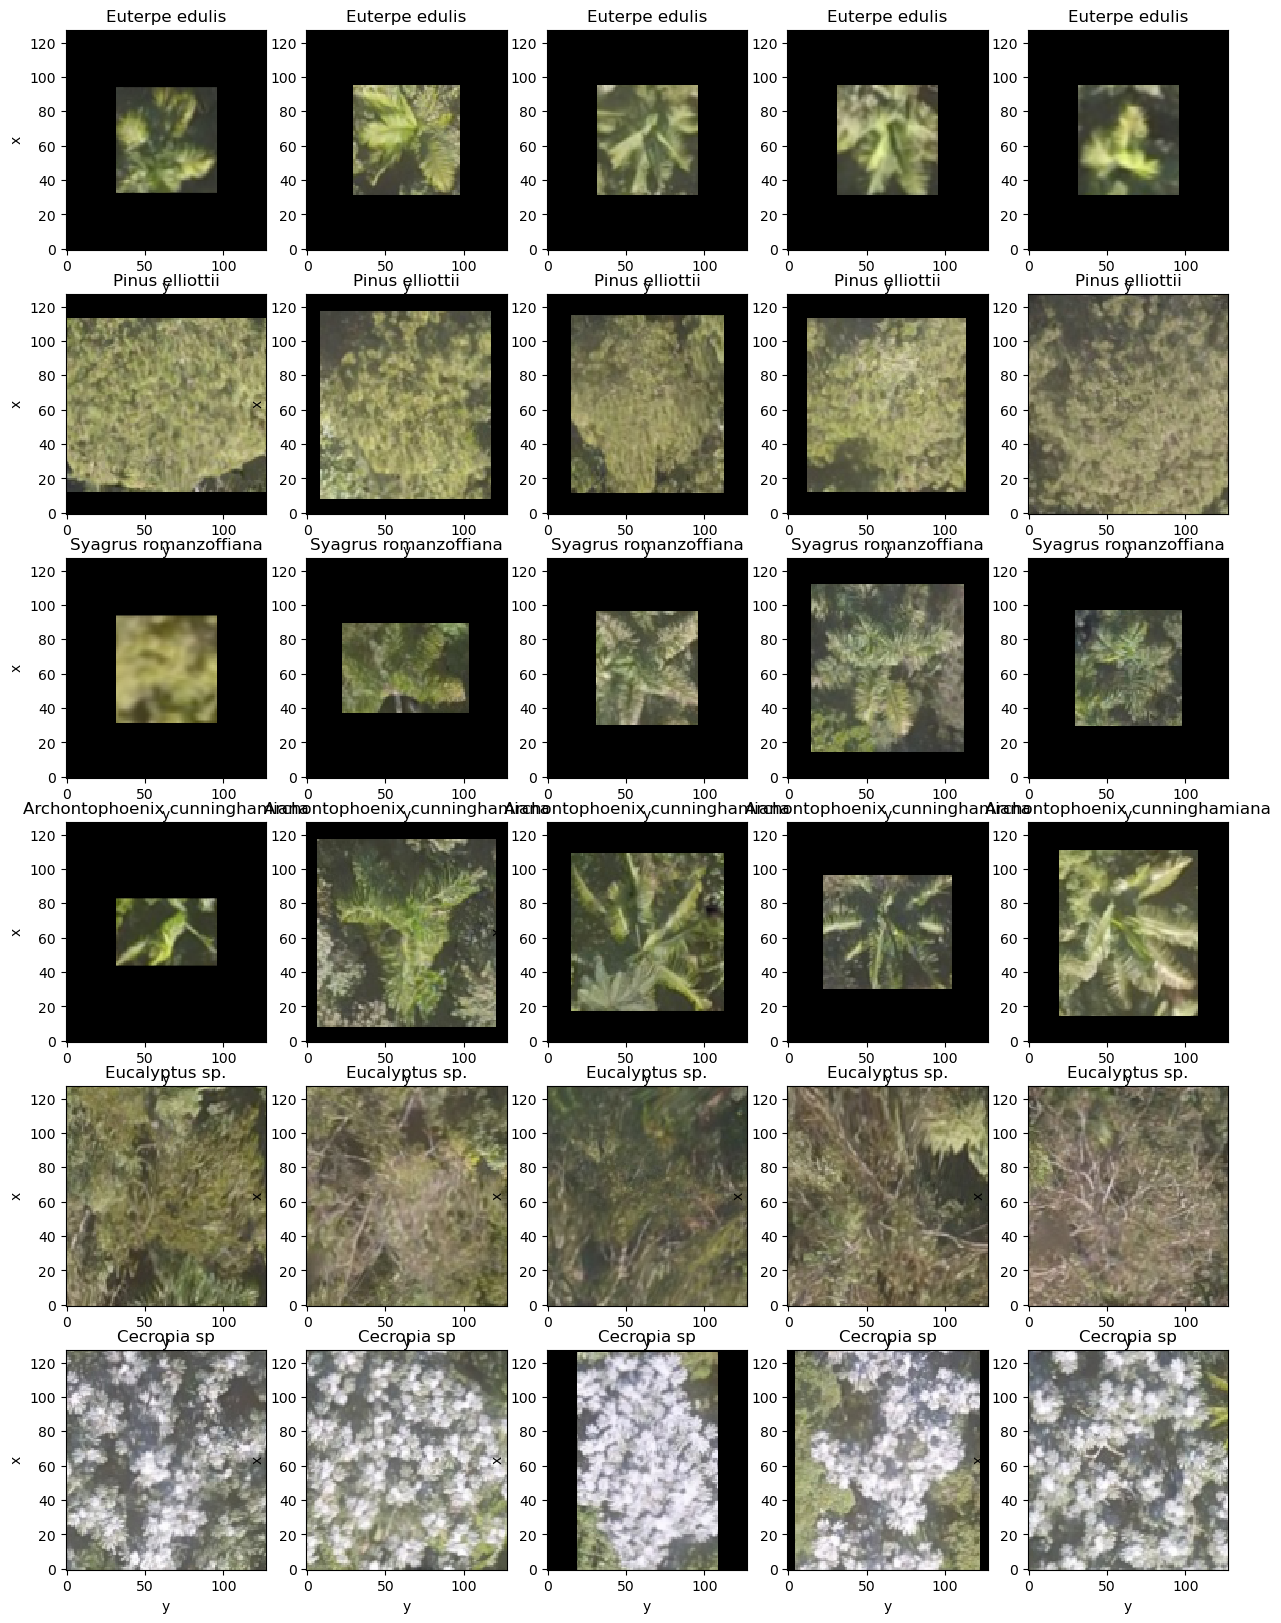

In [33]:
# Plot 5 samples per dataset
# make each dataset a row in subplot

fig, axs = plt.subplots(len(zarr_file_list), 5, figsize=(15, 20))
for i, zarr_file in enumerate(zarr_file_list):
    ds = xr.open_zarr(zarr_file)
    species_name = ds.attrs[str(ds['Y'].isel(sample=0).values.astype(int))]['ESPECIE']

    # andomly plot 5 images
    rng = np.random.default_rng(seed=42)
    indices = rng.permutation(ds.sizes['sample'])
    for j in range(5):
        cutout = ds['X'].isel(sample=indices[j])/255.
        cutout.plot.imshow(ax=axs[i, j])
        axs[i, j].set_title(f'{species_name}')

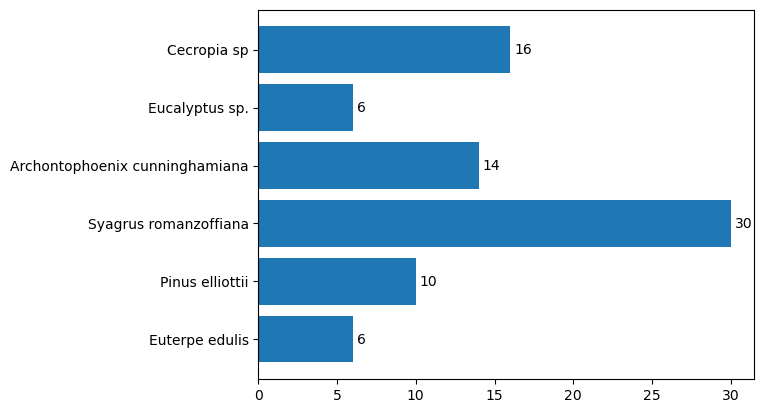

In [34]:
# Make a horizontal bar plot of the number of samples per dataset
ds_list = [xr.open_zarr(zarr_file) for zarr_file in zarr_file_list]
n_samples = [ds.sizes['sample'] for ds in ds_list]
labels = [ds.attrs[str(ds['Y'].isel(sample=0).values.astype(int))]['ESPECIE'] for ds in ds_list]

fig, ax = plt.subplots()
ax.barh(labels, n_samples)
# add number of samples to the right of the bars
for i, v in enumerate(n_samples):
    ax.text(v + 0.25, i, str(v), color='black', va='center')